In [19]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import optimize as op
import pandas as pd
from scipy.stats import multivariate_normal
import pymc3 as pm
%matplotlib inline

Motter 2009 finds that if V4 receptive fields are plotted in the coordinates of V1 (roughly a log polar transform of visual space) then receptive fields are well described by a guassian surface with constant width (SD) with respect to eccentricity. If receptive fields are fit in visual space coordinates then the SD changes with eccentricity and the guassian surface fit is not good because the receptive fields are skewed away from the fovea. 

This suggests it is better to find RF profiles in the coordinates of V1 as the only parameter to estimate would be the center of the receptive field and thus our estimates would be more accurate. Even if we do estimate the size of the receptive field we would expect there to be less correlation between estimates of SD and receptive field position. 

Motter models V1 as a 3-d surface (football shaped) onto which visual space a 2-d surface is mappped.

The equations which Motter uses to perform this mapping from visual space to V1 takes:

$$v(\theta, w)\rightarrow c(r,z,\phi)$$

where $\theta$ is azimuth and $w$ eccentricity in visual space. $r$ is the radius of the football, $z$ is the distance measured through the football, and $\phi$ the angle looking head on at the point of the football.

The transform is as follows:

$$r= M(w) sin(w)$$

$$z=\int_0^w [M(w)^2-(\frac{dr}{dw})^2]^{0.5} dw$$

$$\phi=\theta$$

The function $M(w) \ (\frac{mm}{\text{deg}})$ is the cortical magnification factor which is the number of millimeters on cortex corresponding to a degree visual angle as a function of eccentricity.

The authors use the CMF for macaques takes from Levay et. al. (1985) in the paper written as:
$M(w)_a = 100(0.8 + w)^{-2}$ but this is for magnification in square mm per square degree visual angle so for the formula above we take the square root.
$$M(w) = 10(0.8 + w)^{-1}$$

From the formula we see $r$ and $z$ are purely a function of eccentricity $w$ and theta is a direct mapping.

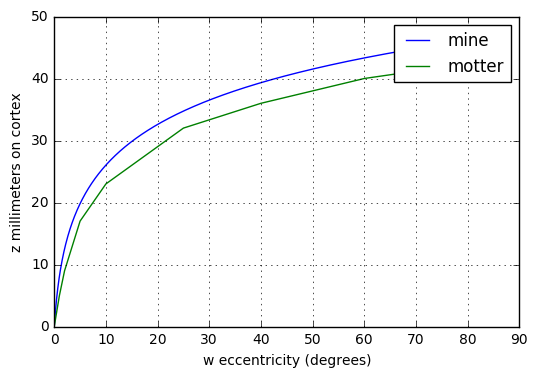

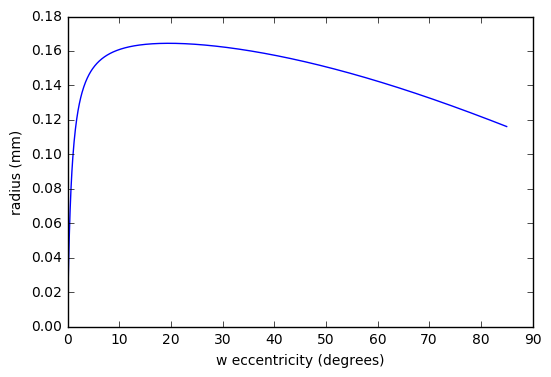

In [3]:
w = np.linspace(0,85,1000)
dw = w[1]-w[0]

a = 103 
b = 0.82 
x = 2.28

a = 100 
b = 0.8
x = 2

mw = np.sqrt(a/(b+w)**x)#had to change this to nine to get it to fit.

r = mw*np.sin(np.deg2rad(w))

drdw = np.gradient(r,dw)

z = integrate.cumtrapz((mw**2.-drdw**2.)**0.5, 
                          dx=dw, initial=0)

plt.plot(w,z);
plt.xlabel('w eccentricity (degrees)');
plt.ylabel('z millimeters on cortex');
plt.grid();


wm = [0, 1,2,5,10,15,25,40,60,85]
zm = [0, 5, 9, 17, 23, 26,32, 36,40, 43]
plt.plot(wm,zm);
plt.legend(['mine', 'motter']);
plt.figure()
plt.plot(w, r);
plt.xlabel('w eccentricity (degrees)');
plt.ylabel('radius (mm)')
plt.figure()
#plt.imshow(plt.imread('/Users/deanpospisil/Desktop/mot.png'));plt.xticks([]);plt.yticks([])

I am not sure why but mine seems to overshoot Motter's. I am going to move forward and build the fitting procedure around this mapping and the mapping can be fixed later.

In [695]:
from pymc3.model import modelcontext, get_named_nodes_and_relations
from pymc3.util import is_transformed_name, get_untransformed_name
from tqdm import tqdm


def sample_prior(samples=500, model=None, vars=None, size=None,
                 random_seed=None, progressbar=True):
    """Generate samples from the prior of a model.

    Parameters
    ----------
    samples : int
        Number of samples from the prior to generate. Defaults to 500.
    model : Model (optional if in `with` context)
    vars : iterable
        Variables for which to compute the posterior predictive samples.
        Defaults to `model.named_vars`.
    size : int
        The number of random draws from the distribution specified by the
        parameters in each sample of the trace.
    random_seed : int
        Seed for the random number generator.
    progressbar : bool
        Whether or not to display a progress bar in the command line.

    Returns
    -------
    dict
        Dictionary with the variables as keys. The values are arrays of prior samples.
    """

    model = modelcontext(model)

    if vars is None:
        vars = set(model.named_vars.keys())

    if random_seed is not None:
        np.random.seed(random_seed)

    if progressbar:
        indices = tqdm(range(samples))

    def step(model):
        point = {}
        for var in model.basic_RVs:
            var_name = var.name
            if hasattr(var, 'distribution'):
                if is_transformed_name(var_name):
                    val = var.distribution.dist.random(
                        point=point, size=size)
                    var_name_untranf = get_untransformed_name(var_name)
                    point[var_name_untranf] = val
                    val = var.distribution.transform_used.forward_val(val)
                else:
                    val = var.distribution.random(point=point, size=size)
            else:
                nn, _, _ = get_named_nodes_and_relations(var)
                val = var.eval({model.named_vars[v]: point[v]
                                for v in nn})

            point[var_name] = val
        return point

    try:
        prior = {var: [] for var in vars}
        for _ in indices:
            point = step(model)
            for var_name, var in model.named_vars.items():
                if var_name in vars:
                    if var_name in point:
                        val = point[var_name]
                    else:
                        nn, _, _ = get_named_nodes_and_relations(var)
                        val = var.eval({model.named_vars[v]: point[v]
                                        for v in nn})
                    prior[var_name].append(val)

    except KeyboardInterrupt:
        pass

    finally:
        if progressbar:
            indices.close()

    return {k: np.asarray(v) for k, v in prior.items()}

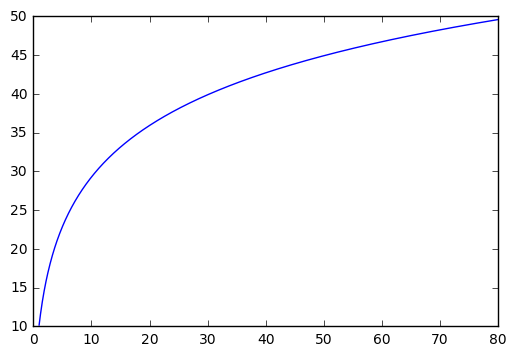

In [4]:
def v_to_c(x,y):
    winit = (x**2. + y**2.)**0.5
    
    w = np.linspace(0,winit,1000)
    dw = w[1]-w[0]
    mw = np.sqrt(100/(.8+w)**2)#had to change this to nine to get it to fit.

    r = mw*np.sin(np.deg2rad(w))

    drdw = np.gradient(r,dw)
 
    z = integrate.trapz((mw**2.-drdw**2.)**0.5, 
                              dx=dw)
    
    phi = np.arctan(y/x)
    x, y = np.array([np.cos(phi), np.sin(phi)])*r[-1]
    return x, y, z


y = np.linspace(1,80,1000);
x = y
xyz = np.array([v_to_c(ay,ay) for ax,ay in zip(x,y)]).squeeze()
plt.plot(y, xyz[:,-1])



In [863]:
import xarray as xr
import sys
import os 
import re

def get_ti_dat(i):
    topdir = '/Users/deanpospisil/Desktop/modules/ipython_nb/rf_char_stim_exp/ti_pool_ad_exps_dat_struct/'
    fns = [f for f in os.listdir(topdir) if 'ti_' in f][1:]

    fn = fns[i]

    a = re.findall('\d+',fn)[0]
    
    orig_fn = ('/Users/deanpospisil/Desktop/modules/ipython_nb/rf_char_stim_exp/rf_char_stim_' 
    + a +'/')
    #print(orig_fn)
    fnss = [f for f in os.listdir(orig_fn) if '.nc' in f] 

    o = xr.open_dataset(orig_fn+fnss[0])
    rfx = (o.attrs['rfx']-600)/40.
    rfy = (o.attrs['rfy']-600)/40.
    sw = (o.attrs['stimWidth']-600)/40.

    da = xr.open_dataset(topdir + fn)['__xarray_dataarray_variable__']
    da.coords['ecc'] = da.coords['ecc'].values*sw
    da.coords['rot'] = da.coords['rot'].values*sw
    
    n_trial = len(da.dropna('trial', how='all').coords['trial'])

    #print((rfx**2+rfy**2)**0.5/40)
    if len(da.coords['unit'])>1:
        da = ((da)).sel(unit=1)
        m = da.mean('trial', skipna=True).squeeze()
        v = da.var('trial', skipna=True).squeeze()

        return m, v, rfx, rfy, n_trial, sw, o
    else:
        return None

def get_orig(i):
    topdir = '/loc6tb/data/responses/exp/rf_char_stim_exp/ti_pool_ad_exps_dat_struct/'
    topdir = '/Users/deanpospisil/Desktop/modules/ipython_nb/rf_char_stim_exp/ti_pool_ad_exps_dat_struct/'
    
    fns = [f for f in os.listdir(topdir) if 'ti_' in f][1:]
    fn = fns[i]
    a = re.findall('\d+',fn)[0]
    
    orig_fn = ('/Users/deanpospisil/Desktop/modules/ipython_nb/rf_char_stim_exp/rf_char_stim_' 
    + a +'/')
    #print(orig_fn)
    fnss = [f for f in os.listdir(orig_fn) if '.nc' in f]     

    o = xr.open_dataset(orig_fn+fnss[0])
    rfx = (o.attrs['rfx']-600)/40.
    rfy = (o.attrs['rfy']-600)/40.
    sw = (o.attrs['stimWidth']-600)/40.
    

    
    fn = fns[i]
    da = xr.open_dataset(topdir + fn)['__xarray_dataarray_variable__']
    da.coords['ecc'] = da.coords['ecc'].values*sw
    da.coords['rot'] = da.coords['rot'].values*sw
    da.attrs['rfx'] = rfx
    da.attrs['rfy'] = rfy
    return fn, da

In [54]:
topdir = '/Users/deanpospisil/Desktop/modules/ipython_nb/rf_char_stim_exp/ti_pool_ad_exps_dat_struct/'
fns = [f for f in os.listdir(topdir) if 'ti_' in f][1:]
print(fns)


['ti_l181023DeansExp', 'ti_l181024DeansExp', 'ti_l181025DeansExp', 'ti_l181026DeansExp', 'ti_l181029DeansExp', 'ti_l181030DeansAdaptive', 'ti_l181030DeansExp', 'ti_l181030DeansExp2', 'ti_l181031DeansExp2', 'ti_l181101DeansExp']


1
1
2
2
3
3
6
6
7
7
8
8
9
9


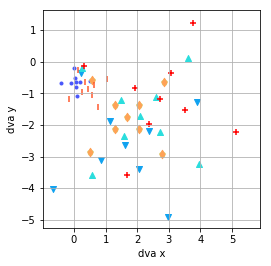

In [61]:
markers = ['', '.', 'v', '^', '1', 's', 'p', 'd', '|', '+', 'D']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
dats=[]
good_units = np.array([1,2,3,6,7,8,9])
#good_units = range(len(fns))
for i in good_units:
    
    a = get_ti_dat(i)
    if not a==None:
        print(i)
        m, v, rfx, rfy, n_trial, sw, o = get_ti_dat(i)
    #    print(sw)
    #    print(rfx)
    #    print(rfy)
    

    m = m.transpose('rot', 'ecc', 'stim')
    ms = []
    eccs = []
    rots = []
    resps=[]
    for r in m:
        for e in r:
            if sum(np.isnan(e.values))==0:
                resps.append(e.values)
                eccs.append(e.coords['ecc'].values)
                rots.append(e.coords['rot'].values)
    if len(eccs)>0:
        
        eccs = np.array(eccs)
        rots = np.array(rots)

        er = np.array([eccs,rots]).T
        theta = (np.arctan2(rfy, rfx))
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
        xy = np.array([np.dot(rot_mat, a_er) + np.array([rfx,rfy])
                       for a_er in er]).squeeze()  

        if len(xy)>0:
            print(i)
        plt.scatter(xy[:,0], xy[:,1], c=colors[i], marker=markers[i]);plt.axis('square');
        plt.xlabel('dva x');
        plt.ylabel('dva y');
        dat = np.concatenate([xy,resps],1)[np.newaxis]
        dats.append(dat)
plt.grid()

[[ 0.    -2.625]
 [ 0.    -0.875]
 [-2.625  0.   ]
 [-0.875  0.   ]
 [ 0.     0.   ]
 [ 0.875  0.   ]
 [ 2.625  0.   ]
 [ 0.     0.875]
 [ 0.     2.625]]
-23.325350881


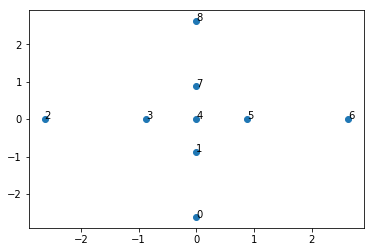

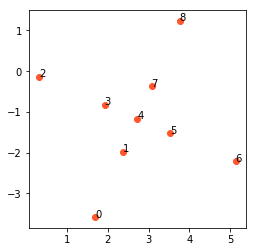

In [65]:
plt.scatter(eccs,rots)
for i in range(9):
    plt.text(eccs[i], rots[i], str(i));
er = np.array([eccs,rots]).T
print(er)
theta = (np.arctan2(rfy, rfx)) 
rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
xy = np.array([np.dot(rot_mat, a_er)+np.array([rfx,rfy])
               for a_er in er]).squeeze()  

plt.figure()
plt.scatter(xy[:,0], xy[:,1], c=colors[i]);plt.axis('square');
for i in range(9):
    plt.text(xy[i,0], xy[i,1], str(i));
    
print(np.rad2deg(theta))

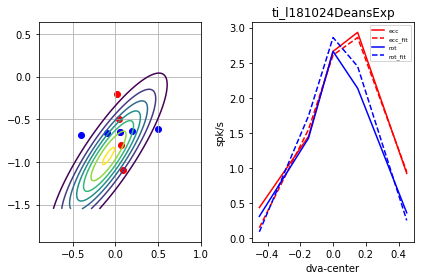

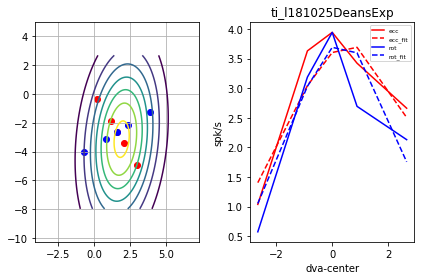

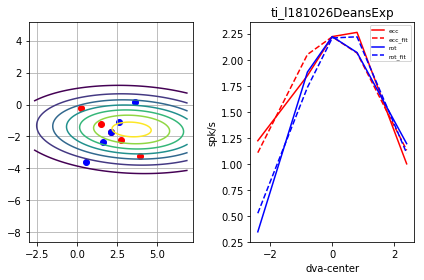

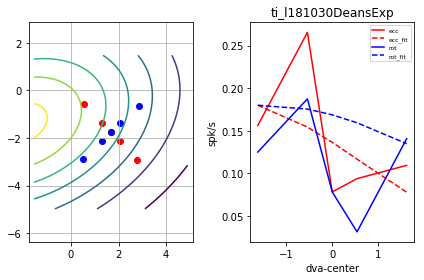

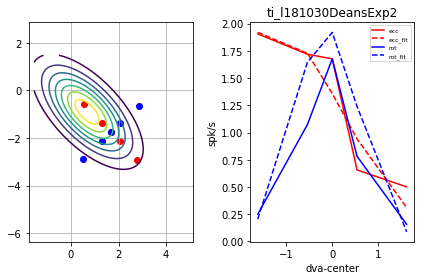

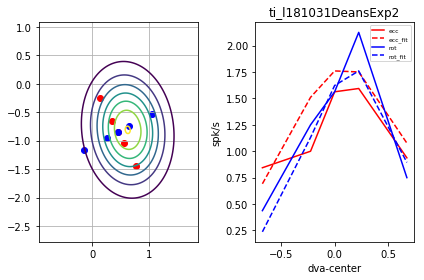

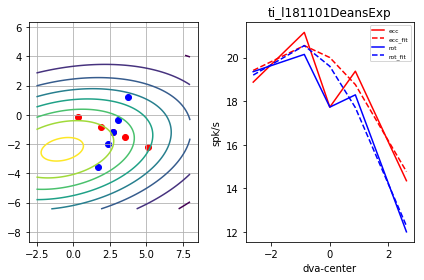

In [829]:
fits = []

rot_ind = np.array([0,1,4,7,8])
ecc_ind = np.array([2,3,4,5,6])

def gaussian2(pos, amp=1, mux=1, muy=1, varx=1, vary=1, r=0):
    #assume pos is n samps X 2
    #covxy=0
    
    resp = multivariate_normal([mux, muy], 
                                   [[varx, r*(varx*vary)**0.5], 
                                    [r*(varx*vary)**0.5, vary]]).pdf(pos)
    resp= resp/np.max(resp)
    resp = resp*amp 
    return resp

f = gaussian2

for i in range(len(dats)):
    dat = dats[i].squeeze()
    df = pd.DataFrame(dat, columns=['x', 'y',] + list(range(16)))
    resp = df.iloc[:,2:]
    xy = df.iloc[:,:2].values

    resps = np.array(resps)
    width = np.linalg.norm(xy[2,] - xy[6])*1

    x = xy
    y = resp.mean(1)
    cx , cy = np.mean(x,0)
    amp_init = np.mean(y)
    sd = ((cx**2 + cy**2)**0.5)
    
    popt, pcov=  op.curve_fit(f, x, y, 
    bounds=([0, -np.inf, -np.inf, 0, 0,-1], 
            [np.inf, np.inf,  np.inf,  np.inf,  np.inf,1]),
                             p0=[amp_init, cx, cy, sd, sd, 0.3]
                             )

    fits.append(pd.DataFrame(np.round(popt,2), 
                       index=['amp', 'x', 'y', 'varx', 'vary', 'r' ]))
    

e_ind = np.array([])
for i in range(len(dats)):
    dat = dats[i].squeeze()
    df = pd.DataFrame(dat, columns=['x', 'y',] + list(range(16)))
    resp = df.iloc[:,2:]
    xy = df.iloc[:,:2].values
    center = xy[4,:]
    width = np.linalg.norm(xy[2] - xy[6])

    fit = fits[i]
    amp, mux, muy, varx, vary, r = fit.values.squeeze()
    lims = varx+vary + r*(varx*vary)**0.5
    cbound = 0.1
    xi = np.linspace(center[0]-width, center[0]+width, 1000)
    yi = np.linspace(center[1]-width, center[1]+width, 1000)
    x, y = np.meshgrid(xi,yi)
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    plt.figure()
    plt.subplot(121)
    resp_fit = gaussian2(pos, amp, mux, muy, varx, vary, r)
    plt.contour(x,y,resp_fit,);
    plt.scatter(xy[ecc_ind,0], xy[ecc_ind,1], color='r');plt.grid();
    plt.scatter(xy[rot_ind,0], xy[rot_ind,1], color='b');plt.grid();

    
    plt.axis('equal');
    plt.grid()
    plt.subplot(122)
    fn, da = get_orig(good_units[i])
    
    pos = xy[ecc_ind]
    resp_fit_ecc = gaussian2(pos, amp, mux, muy, varx, vary, r)
    plt.plot(da.coords['ecc'].values, 
             resp.mean(1).values[ecc_ind], color='r')
    plt.plot(da.coords['ecc'].values, resp_fit_ecc, color='r',
             linestyle='--')
    plt.title(fn)
    
    

    pos = xy[rot_ind]
    resp_fit_rot = gaussian2(pos, amp, mux, muy, varx, vary, r)
    plt.plot(da.coords['rot'].values, 
             resp.mean(1).values[rot_ind], color='b')
    plt.plot(da.coords['rot'].values, resp_fit_rot, color='b',
             linestyle='--')
    plt.ylabel('spk/s')
    plt.xlabel('dva-center')
    plt.legend(['ecc','ecc_fit', 'rot', 'rot_fit'], prop={'size': 6})
    plt.tight_layout()
    
    

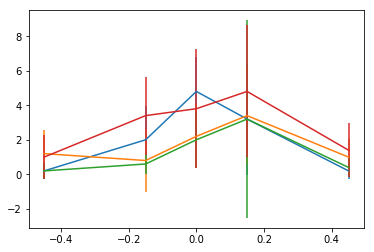

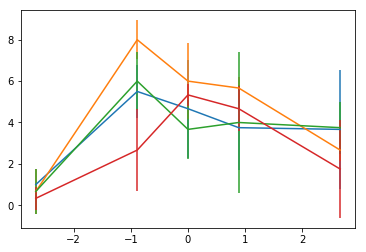

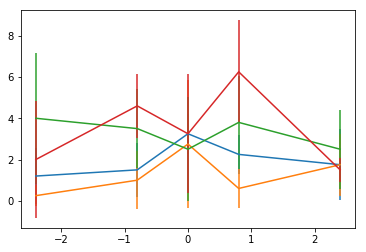

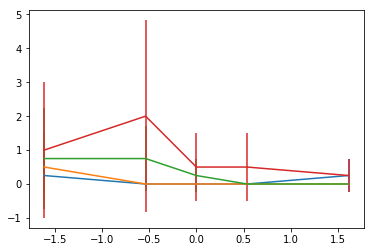

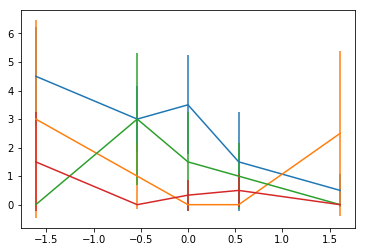

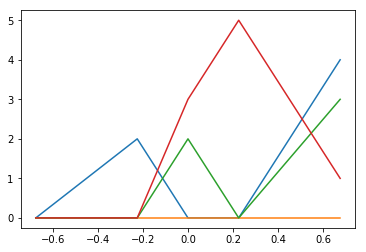

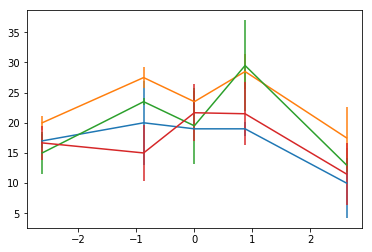

In [67]:
for j in good_units:
 
    m, v, rfx, rfy, n_trial, sw, o = get_ti_dat(j)
    plt.figure()
    m = m.sel(rot=0)
    v = v.sel(rot=0)
    #m.sel(stim=[14,15,]).plot.line(x='ecc')
    for i in [12, 13,14,15]:
        am = m.sel(stim=i).values
        av = v.sel(stim=i).values
        plt.errorbar(m.coords['ecc'], am, yerr=2*(av**0.5)/3**0.5)
    

One clear difficulty with this method is that it tends to overfit/be unstable. One way to get around this is to use a bayesian method where we put priors on the parameters. So for example we wouldn't expect the center of the  RF to be very far from the initial mapping (e.g. unlikely to be on the other side of fixation or where the last couple penetrations were, or not to be more than double what the RF formula would give). 

Our bayesian model will be:

$$R_i \sim NB[\mu=f(a, \mu_x, \mu_y, \sigma_x, \sigma_y, r \ | \ x_i, y_i), \alpha=\alpha)]$$

where

$$f=a \exp((\vec{x}-\vec{\mu})^T \Sigma^{-1} (\vec{x}-\vec{\mu})^T )$$

a 2d gaussian with amplitude $a$, $\Sigma=  \begin{bmatrix} \sigma_x^2 & r \sigma_x \sigma_y  \\ r\sigma_x \sigma_y & \sigma_y^2  \\  \end{bmatrix}$, and $\vec{\mu}= \begin{bmatrix} \mu_x  \\ \mu_y \\  \end{bmatrix}$
   
$r$ here accounts for orientation of the RF, $\sigma$ for size, $\vec{\mu}$ for the center, and $a$ for the amplitude $\vec{x}$ is fixed and is the position of the stimulus.

So each response is a draw from a negative binomial with expected value according to this response surface and variability scaled by $\alpha$.

so for each of the parameters which generate these samples we have to put a prior on it. 

to a first approximation we will take the average SD of V4 as a function eccentricity in degrees to be:
$$2 E[\sigma] = 3+\frac{3}{4}e$$ with $e = |E[\vec{\mu}]|$ the distance of RF center from fovea.

when the experiment begins the experimenter will provide an estimate of the center of the RF based on handmapping we will take this as the mean of our prior on $\vec{\mu}$.
Then the mean on the prior for $\sigma$ will be $\frac{3+\frac{3}{4}|E[\vec{\mu}]|}{2}$

we will guess that roughly we at most expect RF's to be twice or half as large as this and we expect at most for the rf center to be one estimated RF width away.

so we have

$$\sigma_{xy} \sim \Gamma(loc=\frac{3+\frac{3}{4}|E[\vec{\mu}]|}{2},SD= \frac{3+\frac{3}{4}|E[\vec{\mu}]|}{4})$$

$$\vec{\mu} \sim N(loc=E[\vec{\mu}] ,SD= \frac{3+\frac{3}{4}|E[\vec{\mu}]|}{2}I_2)$$

we don't expect a huge amount of tilt in the receptive field but there could be some and we must be restricted to $(-1,1)$:

$$r \sim U(-.95, .95)$$

For amplitude we will take as a prior mean the estimated response rate at the estimated center of the receptive field
$$a \sim  \Gamma(\text{loc}=\bar{X}, sd=s^2/\sqrt{n})$$

Finally for $\alpha$ eye balling a figure from Goris et al. but I should check on previously examined data.
$$ \alpha ~  \Gamma(\text{loc}=0.75, sd=1)$$

So now I have priors on all the data lets give this a try the date we will fit is for responses from a single unit for one stimuli in 1-d just to get a sense

In [393]:
traces=[]
init_sample = 1
end_sample = 25
samples = range(init_sample, end_sample,1)
samples = [init_sample, 2, 3, 4, 5, 6, 10, 15, 20, 25]
samples = [init_sample, 2, 3, 4, 10,25]
shuffle_inds = np.random.permutation(len(resp))

In [802]:
np.random.seed(12345)
i = 1
gi = good_units[i]

dat = dats[i].squeeze()
df = pd.DataFrame(dat, columns=['x', 'y',] + list(range(16)))
resp = df.iloc[ecc_ind, -2]
xy = df.iloc[ecc_ind,:2].values
center = xy[4,:]
fn , da = get_orig(gi)
da = da.sel(rot=0).dropna('trial', how='any')
ecc = np.sum(xy**2, 1)**0.5
da.coords['ecc'] = ecc


Y = da.isel(unit=1).transpose('stim', 'ecc','trial')

mu_a = Y.isel(ecc=2).mean('trial').values
n_stim = len(mu_a)

sw = (Y.coords['ecc'][2].values - Y.coords['ecc'][1].values)

resp = Y.to_dataframe()
x = np.array([ax for ax in resp.index])
stim_id = x[:,0].astype(int)
ecc = x[:,1]
resp = resp.values[:,-1]
resp = pd.DataFrame(np.array([stim_id, ecc, resp]).T, columns=['id', 'ecc', 'resp'])

In [823]:
def simulate_1d_gaus(params, resp, mu_a, get_prior=False):
    basic_model = pm.Model()
    with basic_model: 
        u_stim = np.unique(resp['id'].values).astype(int)
        stim_id_ind = np.argsort(u_stim)
        u_stim = u_stim[stim_id_ind]
        n_stim = len(u_stim)
        print(u_stim)
        mu_a  = mu_a[u_stim]
        print(mu_a)
        stim_id = resp['id'].values.astype(int)
        stim_id_resp_ind = np.array([np.where(u_stim==an_id)[0][0] 
                                    for an_id in stim_id]).astype(int)
        ecc = resp['ecc'].values
        spks = resp['resp']
        
        # Priors for unknown model parameters
        mu = pm.Gamma('mu',mu=params['loc']['mu'], sd=params['scale']['mu'])
        sig = pm.Gamma('sig', mu=params['loc']['sig'], sd=params['scale']['sig'])

        alpha = pm.Gamma('alpha', mu=params['loc']['alpha'], sd=params['scale']['alpha'], shape=1)
        
        a = pm.Gamma('a', mu=mu_a, sd=mu_a, shape=n_stim)
        
        rf1 = gaus(ecc, mu=mu, sig=sig, a=a[stim_id_resp_ind])
        Y_obs = pm.NegativeBinomial('Y_obs', mu=rf1, alpha=alpha,  observed=spks)
        

        print(stim_id_resp_ind)
        if get_prior:
            trace = sample_prior(samples=500)
        else:
            trace = pm.sample(tune=1000)
        return trace
    


In [824]:
from itertools import product
params_list=[]
prior_scales = [0.1,0.5, 1.]
prior_scales = [2,.5]
for prior_scale in prior_scales:    

    params = {'loc':{}, 'scale':{}}
    params['loc']['mu'] = e
    params['loc']['sig'] = sw
    params['loc']['alpha'] = 1

    params['scale']['mu'] = sw*prior_scale
    params['scale']['sig'] = sw*prior_scale
    params['scale']['alpha'] = 0.5
    params_list.append(params)
  
samples = [5,20]
sub_ind = np.where(resp['id'].values==15)[0]
inds = np.random.permutation(sub_ind).astype(int)
exps = list(product(samples,range(len(prior_scales))))

traces = []
for ind in exps:
    s = inds[:ind[0]].squeeze()
    a_params = params_list[ind[1]]
    trace = simulate_1d_gaus(a_params, resp.iloc[s], mu_a)
    traces.append(trace)

[15]
[ 5.33333333]


INFO (theano.gof.compilelock): Refreshing lock /Users/deanpospisil/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.5.2-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0 0 0 0 0]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, alpha, sig, mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 226.21draws/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.710284691405, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[15]
[ 5.33333333]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0 0 0 0 0]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, alpha, sig, mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:16<00:00, 184.10draws/s]


[15]
[ 5.33333333]


INFO (theano.gof.compilelock): Refreshing lock /Users/deanpospisil/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.5.2-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, alpha, sig, mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:20<00:00, 145.82draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


[15]
[ 5.33333333]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, alpha, sig, mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 250.64draws/s]


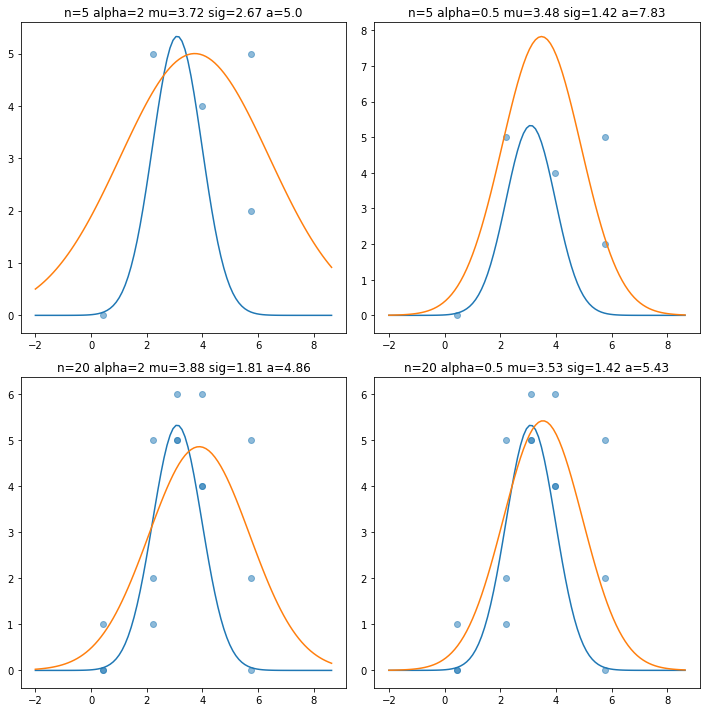

In [825]:
def median(x):
     return pd.DataFrame(pm.quantiles(x, [50,]))
    
def gaus(x, mu=0, sig=1, a=10):
    e = (-(x-mu)**2)/(2*sig**2)
    y = a*np.exp(e)
    return y

exps = np.array(exps)
n = len(samples)
m = len(prior_scales)
ind = 0
plt.figure(figsize=(10,10))
for i, sample in enumerate(samples):
    for j , scale in enumerate(prior_scales):
        s = inds[:sample].squeeze()
        #print(sample)
        #print(inds[:sample])
        s_resp = resp.iloc[s]
        x_orig = resp['ecc'].values
        
        plt.subplot(n,m, ind+1)
        t = traces[ind]
        df = pm.summary(t)['mean']
        dfm = pm.summary(t, stat_funcs=[median,])[50]
        
        plt.title('n='+str(sample) + ' ' +'alpha='+str(scale) 
                  + ' mu='+str(np.round(dfm['mu'],2)) + ' sig='+str(np.round(dfm['sig'],2))
                 + ' a='+str(np.round(dfm['a__0'],2)))
        
        x_new = np.linspace(-2,np.max(x_orig)*1.5, 100)
        
        prior_y = gaus(x_new, mu=params['loc']['mu'], sig=params['loc']['sig'], a=mu_a[15])
        plt.plot(x_new, prior_y)
        
        fit_y = gaus(x_new, mu=dfm['mu'], sig=dfm['sig'], a=dfm['a__0'])

        plt.plot(x_new, fit_y)
        plt.scatter(s_resp['ecc'], s_resp['resp'], alpha=0.5)
        
        
        ind+=1
plt.tight_layout() 

I am having two issues which I am not sure if they are interrelated. First I seem to consistently get convergence warnings and I am not sure how to correct them. I suspect I need to make the distribution more jointly normal. Second when I increase the variability of the negative binomial via alpha it doesn't seem to change the amount that our guesses stick to the data/stick to the prior. When I increase the sigma on the parameters it seems my results stick less to the data and have a bias for higher sigmas. I am going to try least squares and just ignore the results until confidence intervals are outside the priors

In [522]:
prior_scale = 1
params = {'loc':{}, 'scale':{}}
params['loc']['mu'] = e
params['loc']['sig'] = sw
params['loc']['a'] = mu_a
params['loc']['alpha'] = 1

params['scale']['mu'] = sw*prior_scale
params['scale']['sig'] = sw*prior_scale
params['scale']['a'] = params['loc']['a']
params['scale']['alpha'] = 0.5

basic_model = pm.Model()
with basic_model: 
    # Priors for unknown model parameters
    mu = pm.Normal('mu',mu=params['loc']['mu'], sd=params['scale']['mu'])
    sig = pm.Gamma('sig', mu=params['loc']['sig'], sd=params['scale']['sig'])
    a = pm.Gamma('a', mu=mu_a, sd=mu_a, shape=n_stim)#two stimuli
    alpha = pm.Gamma('alpha', mu=params['loc']['alpha'], sd=params['scale']['alpha'], shape=1)#two stimuli
    inds = np.ones(len(resp))
    rf1 = gaus(ecc, mu=mu, sig=sig, a=a[stim_id])
    Y_obs = pm.NegativeBinomial('Y_obs', mu=rf1, alpha=alpha,  observed=resp)
    trace = pm.sample()
    

In [1412]:
np.random.seed(12345)
i = 1
gi = good_units[i]
dat = dats[i].squeeze()
df = pd.DataFrame(dat, columns=['x', 'y',] + list(range(16)))
pos = dat[:,:2]

fn , da = get_orig(gi)

In [1413]:
da


<xarray.DataArray '__xarray_dataarray_variable__' (stim: 16, ecc: 5, rot: 5, trial: 7, unit: 3)>
array([[[[[ nan, ...,  nan],
          ..., 
          [ nan, ...,  nan]],

         ..., 
         [[ nan, ...,  nan],
          ..., 
          [ nan, ...,  nan]]],


        ..., 
        [[[ nan, ...,  nan],
          ..., 
          [ nan, ...,  nan]],

         ..., 
         [[ nan, ...,  nan],
          ..., 
          [ nan, ...,  nan]]]],



       ..., 
       [[[[ nan, ...,  nan],
          ..., 
          [ nan, ...,  nan]],

         ..., 
         [[ nan, ...,  nan],
          ..., 
          [ nan, ...,  nan]]],


        ..., 
        [[[ nan, ...,  nan],
          ..., 
          [ nan, ...,  nan]],

         ..., 
         [[ nan, ...,  nan],
          ..., 
          [ nan, ...,  nan]]]]])
Coordinates:
  * stim     (stim) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * trial    (trial) int32 0 1 2 3 4 5 6
  * ecc      (ecc) float64 -2.662 -0.8875 0.0 0.8875 2.662
  * rot

In [1195]:
def real_to_interval(x,interval):
    y = ((np.arctan(x)+np.pi/2)/np.pi)*(interval[1]-interval[0]) + interval[0]
    return y
def interval_to_real(x, interval):
    y = np.tan((np.pi)*((x - interval[0])/(interval[1]-interval[0]))-np.pi/2)
    return y

y= real_to_interval(100, [0,1])
print(y)
interval_to_real(y, [0,1])


0.996817007235


100.00000000000101

In [1371]:
def gaussian2_fit(d, *args): 
    pos = d[:, :2]
    stim_id = d[:,2]

    u_stim = np.sort(np.unique(stim_id).astype(int))
    stim_id_resp_ind = np.array([np.where(an_id==u_stim)[0][0] 
                            for an_id in stim_id]).astype(int)
    mux = args[0]
    muy = args[1]
    varx = args[2]
    vary = args[3]
    r = args[4]
    avals = np.array(args[5:])

    cov = np.array([[varx, r*(varx*vary)**0.5], 
          [r*(varx*vary)**0.5, vary]])

    resp = multivariate_normal([mux, muy], cov).pdf(pos)

    resp= resp/np.max(resp)

    resp = resp*avals[stim_id_resp_ind]

    return resp
def get_unit_df(rec, unit=0):
    i = rec
    gi = good_units[i]
    fn , da = get_orig(gi)
    m = da.transpose('rot', 'ecc', 'stim', 'trial', 'unit').isel(unit=unit)
    d = m.to_dataframe()
    idx = d.index.values
    rot = np.array([a[0] for a in idx])
    ecc = np.array([a[1] for a in idx])
    stimid = np.array([a[2] for a in idx])

    rfx = m.attrs['rfx']
    rfy = m.attrs['rfy']

    theta = (np.arctan2(rfy, rfx))
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    xy = np.array([np.dot(rot_mat, np.array([e, r])) for e, r in zip(ecc, rot)]) + np.array([rfx, rfy])
    dat = np.concatenate([xy, stimid[...,np.newaxis], 
                          d.values[:,-1][:,np.newaxis], 
                          ecc[:, np.newaxis], rot[:, np.newaxis]], -1)
    d = pd.DataFrame(dat, columns=['x', 'y', 'id', 'resp', 'ecc', 'rot'])
    d = d.dropna().reset_index(drop=True)
    return d

d = get_unit_df(rec=1, unit=0)
args = {'mux':1, 'muy':1, 'varx':1, 'vary':1, 'r':.1}

ds = d.iloc[d['id'].values==15]
#ds = d
pos = ds[['x', 'y']].values

mux = rfx
muy = rfy
varx= 1
vary =1
r = 0

u_stim = np.sort(np.unique(ds['id'].values).astype(int))
stim_id = ds['id'].values.astype(int)

na = len(np.unique(stim_id)) 
p0 = [ mux, muy, varx, vary, r ] + [1 for a in range(na)]

bounds = (([-np.inf, -np.inf,       0,       0, -.9,] + [0 for a in range(na)]), 
          ([np.inf,   np.inf,  np.inf,  np.inf,  .9, ] + [np.inf for a in range(na)]))

popt, pcov=  op.curve_fit(gaussian2_fit, ds[['x','y','id']].values, 
                      ds['resp'].values, 
                      p0=p0,
                      bounds = bounds )

CI = np.diag(pcov)**0.5
print([mux,muy])
res = pd.DataFrame(np.array([popt, se]).T)

[2.1000000000000001, -1.7250000000000001]


,0,1,2
0,2.995467,-3.185756e+07,3.185757e+07
1,-3.231594,-1.449859e+07,1.449858e+07
2,2.489779,-5.672300e+07,5.672301e+07
3,2.069075,-8.383702e+06,8.383706e+06
4,-0.435176,-7.569300e+06,7.569300e+06
5,5.143534,-5.616306e+07,5.616307e+07


In [1694]:
def r_to_c(eps):
    x = 12.*np.log(1+eps)
    return x

def c_to_r(x):
    eps = np.exp(x/12.)-1
    return eps
    
def gaus(x, mu=0, sig=1, a=10):
    e = (-(x-mu)**2)/(2*sig**2)
    y = a*np.exp(e)
    return y
def gaussian1_fit(d, *args): 
    pos = d[:, 0]
    stim_id = d[:, 1]

    u_stim = np.sort(np.unique(stim_id).astype(int))
    stim_id_resp_ind = np.array([np.where(an_id==u_stim)[0][0] 
                            for an_id in stim_id]).astype(int)
    mux = args[0]
    varx = args[1]
    avals = np.array(args[2:])

    resp = gaus(pos, mu=mux,sig=varx)

    resp= resp/np.max(resp)

    resp = resp*avals[stim_id_resp_ind]

    return resp

def fit_gaus1_randc(rec, unit):
    d = get_unit_df(rec=rec, unit=unit)
    ds = d[np.isclose(d['rot'].values,0)]
    ds = ds[ds['id'].values > 10]
    ds['ecc_r'] = (ds['x']**2. + ds['y']**2.)**0.5
    ds ['ecc_c'] =  r_to_c(ds['ecc_r'].values)

    u_stim = np.sort(np.unique(ds['id'].values).astype(int))
    stim_id = ds['id'].values.astype(int)


    mux = ds[ds['ecc']==0]['ecc_c'].iloc[0]
    sw = np.sort(np.unique(ds['ecc_c'].values))
    varx = (sw[3] - sw[2])*2
    mu_amp = ds[ds['ecc']==0].groupby('id').mean()['resp'].values

    na = len(np.unique(stim_id)) 
    p0 = [ mux, varx, ] + [a for a in mu_amp]
    bounds = (([-np.inf,        0,  ] + [0 for a in range(na)]), 
              ([np.inf,    np.inf,  ] + [np.inf for a in range(na)]))

    popt, pcov = op.curve_fit(gaussian1_fit, ds[['ecc_c','id']].values, 
                          ds['resp'].values, 
                          p0=p0,
                          bounds = bounds )
    
    se = np.diag(pcov)**0.5
    index = ['mu', 'sig', ] +['amp' + str(a) for a in u_stim]
    fit_c = pd.DataFrame(np.array([popt, se]).T, columns=['mean', 'se'], index=index)


    mux = ds[ds['ecc']==0]['ecc_r'].iloc[0]
    sw = np.sort(np.unique(ds['ecc_r'].values))
    varx = (sw[3] - sw[2])*2.
    p0 = [ mux, varx, ] + [a for a in mu_amp]

    popt, pcov=  op.curve_fit(gaussian1_fit, ds[['ecc_r','id']].values, 
                          ds['resp'].values, 
                          p0=p0,
                          bounds = bounds )
    se = np.diag(pcov)**0.5
    fit_r = pd.DataFrame(np.array([popt, se]).T, columns=['mean', 'se'], index=index)
    return fit_r, fit_c, ds
    

In [1695]:
#now get mse
#def get_res(ds, u_stim, fit, x):
mse =[]
fits = []

for j in range(len(good_units)):
    fit_r, fit_c, ds = fit_gaus1_randc(j, 1)
    u_stim = np.sort(np.unique(ds['id']))
    fits.append([fit_r, fit_c])
    res_r = []
    res_c = []
    for i in range(len(u_stim)):
        stim_resp = ds[u_stim[i]==ds['id'].values]
        y = stim_resp['resp'].values
        y_hat = gaus(stim_resp['ecc_c'].values, 
                                    mu=fit_c['mean']['mu'],  
                                    sig=fit_c['mean']['sig'], 
                                    a=fit_c['mean'].iloc[2:].iloc[i])
        res_c.append(y-y_hat)
        
        y = stim_resp['resp'].values        
        y_hat =  gaus(stim_resp['ecc_r'].values, 
                                       mu=fit_r['mean']['mu'],  
                                        sig=fit_r['mean']['sig'], 
                                       a=fit_r['mean'].iloc[2:].iloc[i])
        res_r.append( y-y_hat)

    res_r = np.mean(np.concatenate(res_r)**2)
    res_c = np.mean(np.concatenate(res_c)**2)

    mse.append([res_r, res_c])
mse = np.array(mse)

In [1706]:
roc = (mse[:,0]/mse[:,1])
print(roc)
roc = np.argsort(roc)


[ 0.99319047  1.15463674  0.9694482   0.97683071  0.98276061  1.00582712
  0.94289118]


In [1697]:
a = [pd.concat(fit, keys=['r', 'c']) for fit in fits]
b = pd.concat(a, keys=good_units)
b  = b.swaplevel(0,2)

In [1698]:
fits_b = []
fits_s = []
for j in range(len(good_units)):
    fit_r, fit_c, ds = fit_gaus1_randc(j, 0)
    fits_b.append([fit_r, fit_c])
    fit_r, fit_c, ds = fit_gaus1_randc(j, 1)
    fits_s.append([fit_r, fit_c])

In [1699]:
a = [pd.concat(fit, keys=['r', 'c']) for fit in fits_b]
b = pd.concat(a, keys=good_units)
b  = b.swaplevel(0,2)

a = [pd.concat(fit, keys=['r', 'c']) for fit in fits_s]
s = pd.concat(a, keys=good_units)
s  = s.swaplevel(0,2)

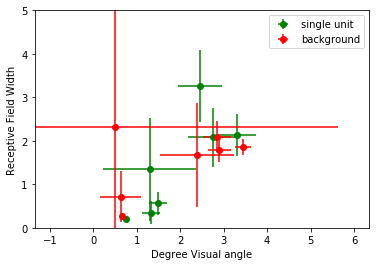

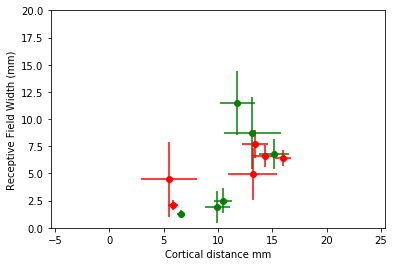

In [1704]:
def plot_rf_params(b, c='k', t='r'):
    yerr = b['se']['sig'][t].values
    inds = yerr<2
    xerr = b['se']['mu'][t].values[inds]
    yerr = yerr[inds]
    y=b['mean']['sig'][t].values[inds]
    x=b['mean']['mu'][t].values[inds]

    plt.errorbar(x=x, y=y, yerr=yerr*2, xerr=xerr*2, marker='o', c=c, linestyle='none')
    if t=='r':
        plt.xlabel('Degree Visual angle');
        plt.ylabel('Receptive Field Width');
    else:
        plt.xlabel('Cortical distance mm');
        plt.ylabel('Receptive Field Width (mm)');
    plt.axis('equal');plt.grid();

plot_rf_params(s, t='r', c='g')
plot_rf_params(b, t='r', c='r')
plt.legend(['single unit', 'background'])
plt.ylim([0,5]);plt.xlim([0,5])

plt.figure()
plot_rf_params(s, t='c', c='g')
plot_rf_params(b, t='c', c='r')
plt.ylim([0,20]);plt.xlim([0,20]);

(0, 20)

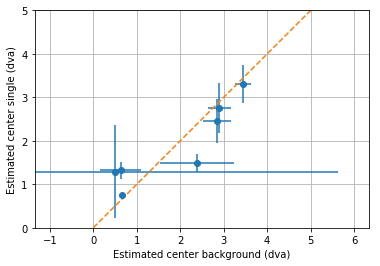

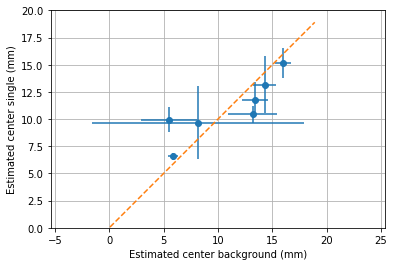

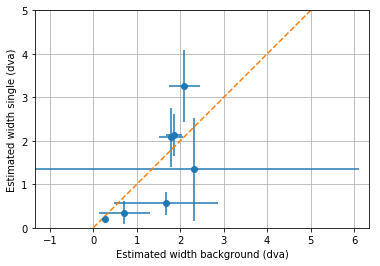

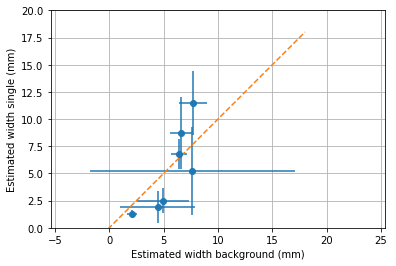

In [1701]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')


y=s['mean']['mu']['r'].values
x=b['mean']['mu']['r'].values
yerr = s['se']['mu']['r'].values
xerr = b['se']['mu']['r'].values
 
plt.errorbar(x=x, y=y, yerr=yerr*2, xerr=xerr*2, marker='o', linestyle='none')
plt.axis('equal');plt.grid();
abline(1,0)
plt.xlabel('Estimated center background (dva)')
plt.ylabel('Estimated center single (dva)')
plt.ylim([0,5]);plt.xlim([0,5])

plt.figure()
y=s['mean']['mu']['c'].values
x=b['mean']['mu']['c'].values
yerr = s['se']['mu']['c'].values
xerr = b['se']['mu']['c'].values
 
plt.errorbar(x=x, y=y, yerr=yerr*2, xerr=xerr*2, marker='o', linestyle='none')
plt.axis('equal');plt.grid();
abline(1,0)
plt.xlabel('Estimated center background (mm)')
plt.ylabel('Estimated center single (mm)')
plt.ylim([0,20]);plt.xlim([0,20])

plt.figure()
y=s['mean']['sig']['r'].values
x=b['mean']['sig']['r'].values
yerr = s['se']['sig']['r'].values
xerr = b['se']['sig']['r'].values
 
plt.errorbar(x=x, y=y, yerr=yerr*2, xerr=xerr*2, marker='o', linestyle='none')
plt.axis('equal');plt.grid();
abline(1,0)
plt.xlabel('Estimated width background (dva)')
plt.ylabel('Estimated width single (dva)')
plt.ylim([0,5]);plt.xlim([0,5])

plt.figure()
y=s['mean']['sig']['c'].values
x=b['mean']['sig']['c'].values
yerr = s['se']['sig']['c'].values
xerr = b['se']['sig']['c'].values
 
plt.errorbar(x=x, y=y, yerr=yerr*2, xerr=xerr*2, marker='o', linestyle='none')
plt.axis('equal');plt.grid();
abline(1,0)
plt.xlabel('Estimated width background (mm)')
plt.ylabel('Estimated width single (mm)')
plt.ylim([0,20]);plt.xlim([0,20])

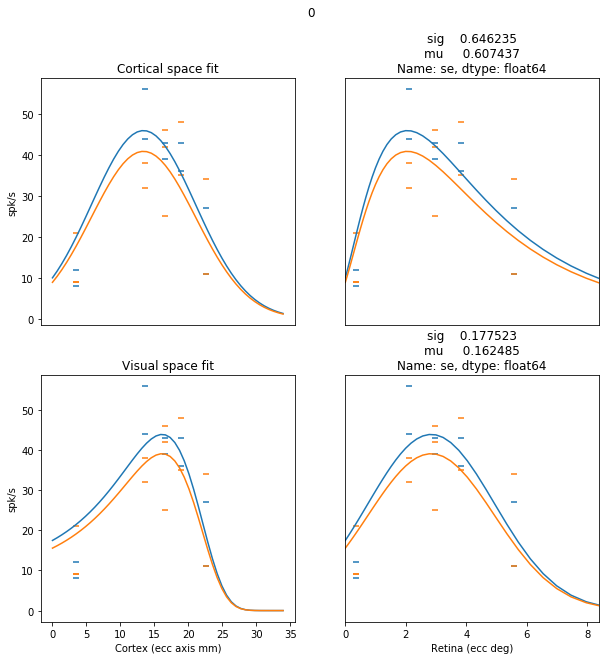

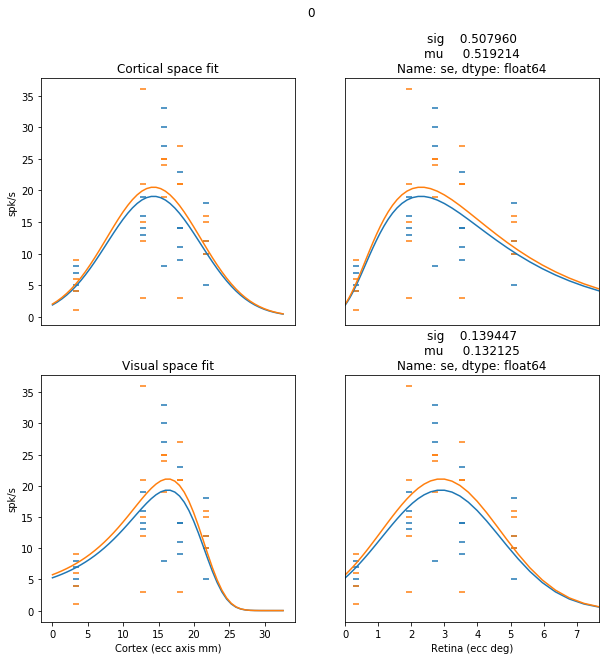

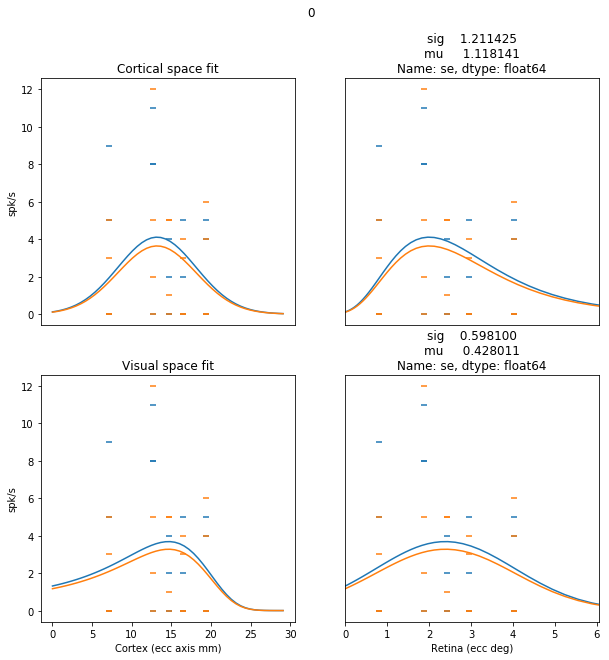

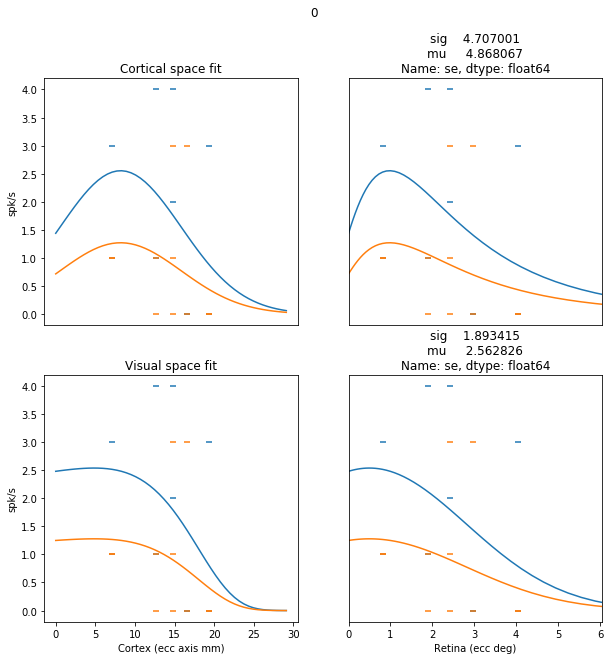

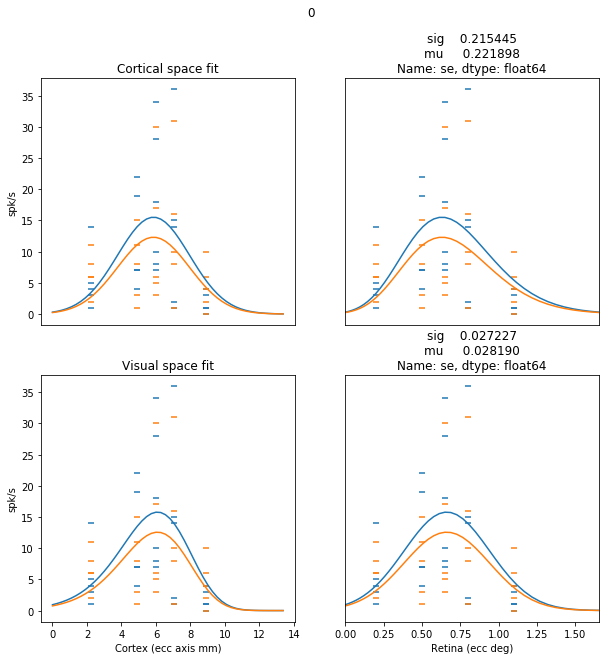

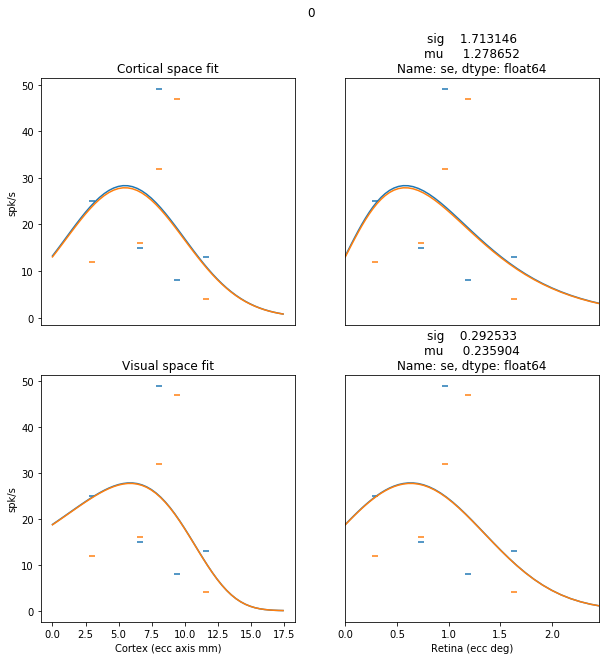

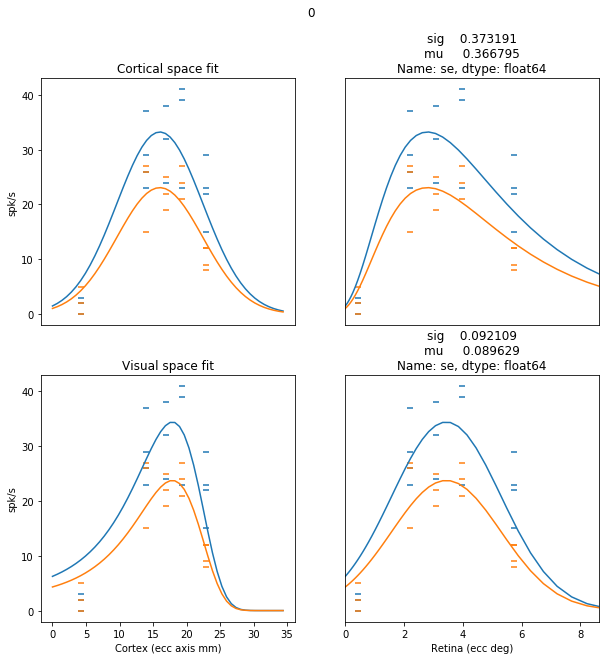

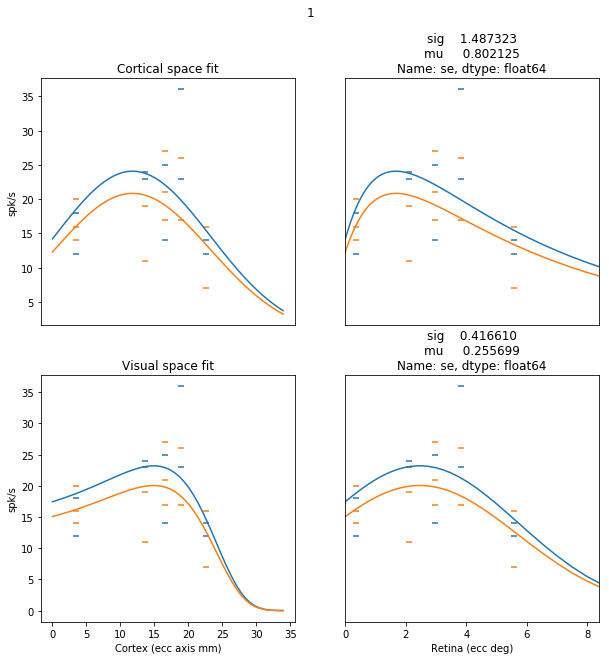

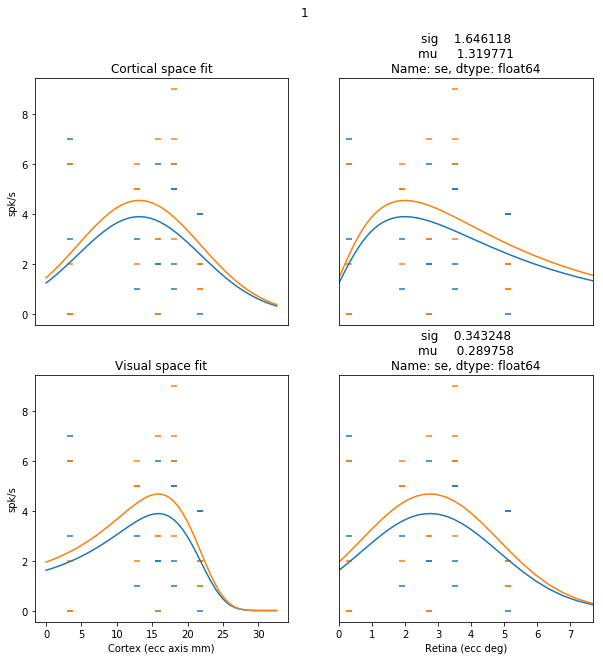

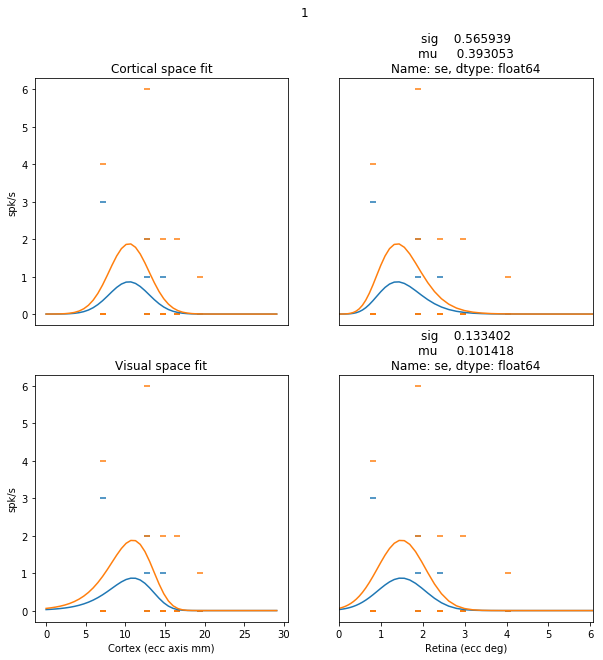

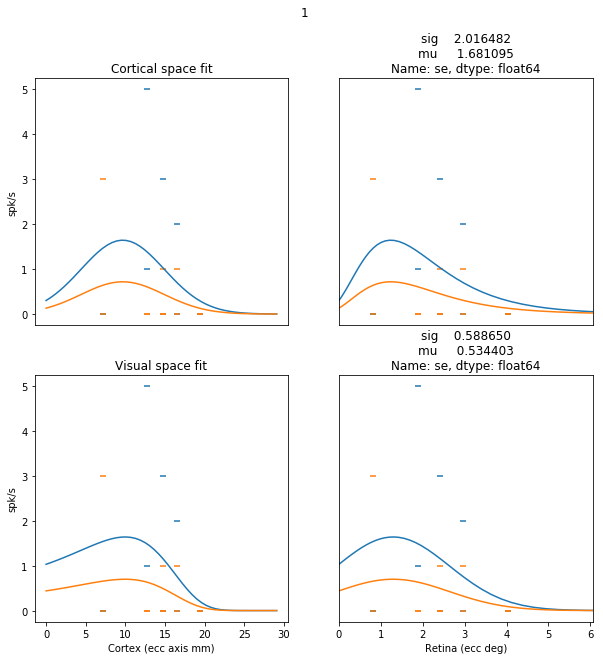

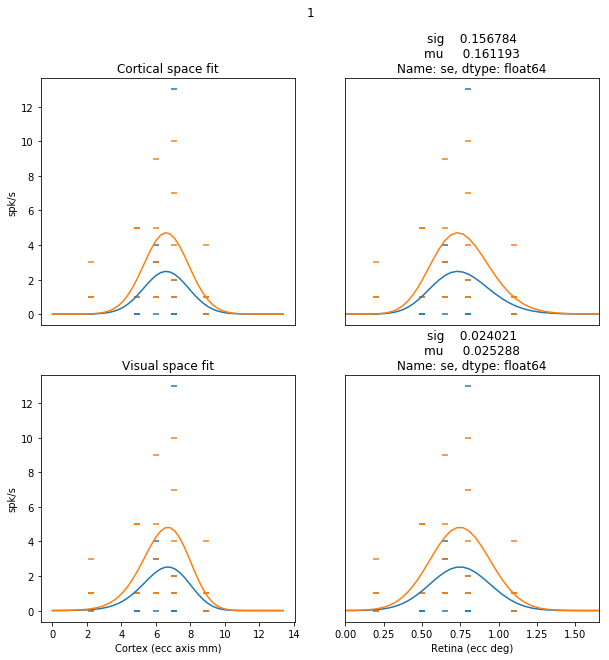

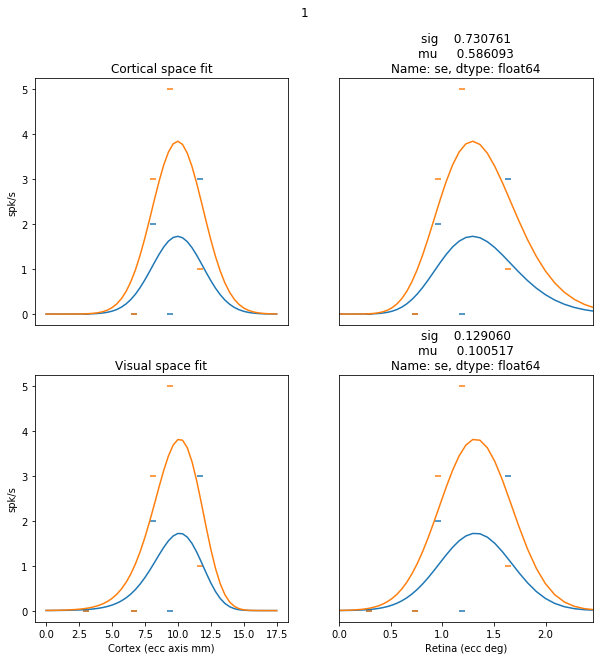

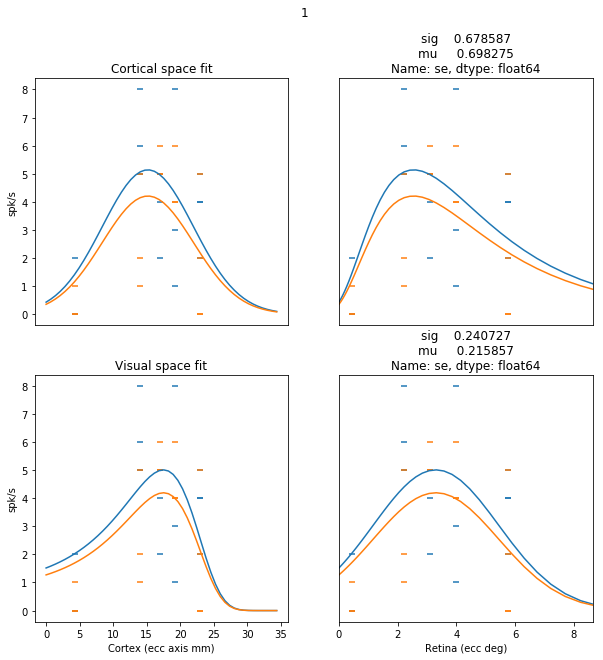

In [1707]:
for unit in range(2):
    for j in roc:
        fit_r, fit_c, ds = fit_gaus1_randc(j, unit)
        newx_c = np.linspace(0, ds['ecc_c'].max()*1.5)
        newx_r = c_to_r(newx_c)
        nstim = 2
        na = len(u_stim)
        plt.figure(figsize=(10,10))
        plt.suptitle(unit)
        plt.subplot(221)
        plt.title('Cortical space fit')
        for i in range(na)[-nstim:]:
            plt.plot(newx_c, gaus(newx_c, mu=fit_c['mean']['mu'],  
                                sig=fit_c['mean']['sig'], 
                                a=fit_c['mean'].iloc[2:][i]))

            stim_resp = ds[u_stim[i]==ds['id'].values]
            plt.scatter(stim_resp['ecc_c'], stim_resp['resp'], marker='_');
            plt.xticks([])
            plt.ylabel('spk/s')

        plt.subplot(222)
        for i in range(na)[-nstim:]:
            plt.plot(newx_r, gaus(newx_c, mu=fit_c['mean']['mu'],  
                                sig=fit_c['mean']['sig'], 
                                a=fit_c['mean'].iloc[2:][i]))
            stim_resp = ds[u_stim[i]==ds['id'].values]
            plt.scatter((stim_resp['ecc_r'].values), stim_resp['resp'], marker='_');

            plt.yticks([])
            plt.xticks([])
            plt.xlim(0,stim_resp['ecc_r'].max()*1.5)
        plt.title(fit_c['se'][['sig', 'mu']])

        plt.subplot(223)
        for i in range(na)[-nstim:]:
            plt.plot(newx_c, gaus(newx_r, mu=fit_r['mean']['mu'],  
                                sig=fit_r['mean']['sig'], 
                                a=fit_r['mean'].iloc[2:][i]))

            stim_resp = ds[u_stim[i]==ds['id'].values]
            plt.scatter(stim_resp['ecc_c'], stim_resp['resp'], marker='_');
            plt.xlabel('Cortex (ecc axis mm)')
            plt.ylabel('spk/s')
        plt.title('Visual space fit') 
        plt.subplot(224)
        for i in range(na)[-nstim:]:
            plt.plot(newx_r, gaus(newx_r, mu=fit_r['mean']['mu'],  
                                sig=fit_r['mean']['sig'], 
                                a=fit_r['mean'].iloc[2:][i]))

            stim_resp = ds[u_stim[i]==ds['id'].values]
            plt.scatter((stim_resp['ecc_r'].values), stim_resp['resp'], marker='_');
            plt.xlabel('Retina (ecc deg)')
            plt.yticks([])
            plt.xlim(0,stim_resp['ecc_r'].max()*1.5)
        plt.title(fit_r['se'][['sig', 'mu']])